In [1]:
##### CS480 Project #####
# Harmony generator 
# Lang Su
# 20630791
# l26su@edu.uwaterloo.ca

In [2]:
# library dependency 
import numpy as np
import pandas as pd
import os
from music21 import *
import matplotlib.pyplot as plt

In [5]:
# return the first note in a music chord object
def get_first_note_from_chord(chord):
    note_lst = [str(n) for n in chord.pitches]
    return note_lst[0]

# takes a path of a midi file, return a list that contains 2 lists of strings
# The first list is melody, the second is harmony
# These lists contains strings of pitch name
# e,g, [C3, A#, *, D3]
# * is a customized char, stand for a rest
def midi_to_note(path):
    piece = converter.parse(path)
    
    if len(piece.parts) != 2:
        print("Not valid for training: {}".format(path))
        return None
    #print(piece.parts[0].__dict__)

    track_list = []
    
    # for each track in the midi file
    for part in piece.parts:
        
        note_to_parse = part.recurse() 

        track = []

        for element in note_to_parse:
            # For note: We use pitch's string expression
            if isinstance(element, note.Note):
                track.append(str(element.pitch))

            # For chord: We take the first note in the chord 
            elif isinstance(element, chord.Chord):
                track.append(get_first_note_from_chord(element))
                
            # For Rest: A rest is a note with no pitch of time length 1.0
            # We express it using a *
            elif isinstance(element, note.Rest):
                track.append("*")
            
        track_list.append(track)

    return track_list

In [6]:
from sklearn.model_selection import train_test_split

# take a path string to the directory of midi files
# return input_streams: melody list for each song
#        output_streams: harmony list for each song
#        max_input_seq_num: the longest length of melody in input stream
#        max_output_seq_num: the longest length of harmony in output stream
def get_input(path_to_dir):
    input_streams = [] # right hand
    output_streams = [] # left hand
    max_input_seq_num = 0
    max_output_seq_num = 0
    counter = 0
    for file in os.listdir(path_to_dir):
        if file.endswith(".mid"):
            full_path = os.path.join(path_to_dir, file)
            result = midi_to_note(full_path)
            if result!=None: # if qualified 2 track midi
                input_streams.append(result[0])
                output_streams.append(result[1])
                counter += 1 

    # decide which stream has the longest length
    max_input_seq_num = max(len(input_stream) for input_stream in input_streams)
    max_output_seq_num = max(len(output_stream) for output_stream in output_streams)
    
    print("Finished {} of midi files. Max input stream length {}, max output stream length {}"\
          .format(str(counter), str(max_input_seq_num), str(max_output_seq_num)))
    
    return input_streams, output_streams, max_input_seq_num, max_output_seq_num

total_input_streams, total_output_streams, max_input_seq_num, max_output_seq_num \
= get_input("./dataset/")
train_input_streams, test_input_streams, train_output_streams, test_output_streams \
= train_test_split(total_input_streams, total_output_streams, test_size=0.1, random_state=42)
print(len(train_input_streams))
print(len(train_output_streams))
print(len(test_input_streams))
print(len(test_output_streams))

Not valid for training: ./train/6c29793a140a811d0c45ce03c1c93a28.mid
Not valid for training: ./train/07c5807d0d927dcd0980f86024e5208b.mid
Not valid for training: ./train/92bbd31f8e0e43a7da8a6295b251725f.mid
Not valid for training: ./train/5b69b9cb83065d403869739ae7f0995e.mid
Not valid for training: ./train/d3a7f48c12e697d50c8a7ae7684644ef.mid
Not valid for training: ./train/298f587406c914fad5373bb689300433.mid
Finished 114 of midi files. Max input stream length 368, max output stream length 343
102
102
12
12


Found 79 keys used in all midi files


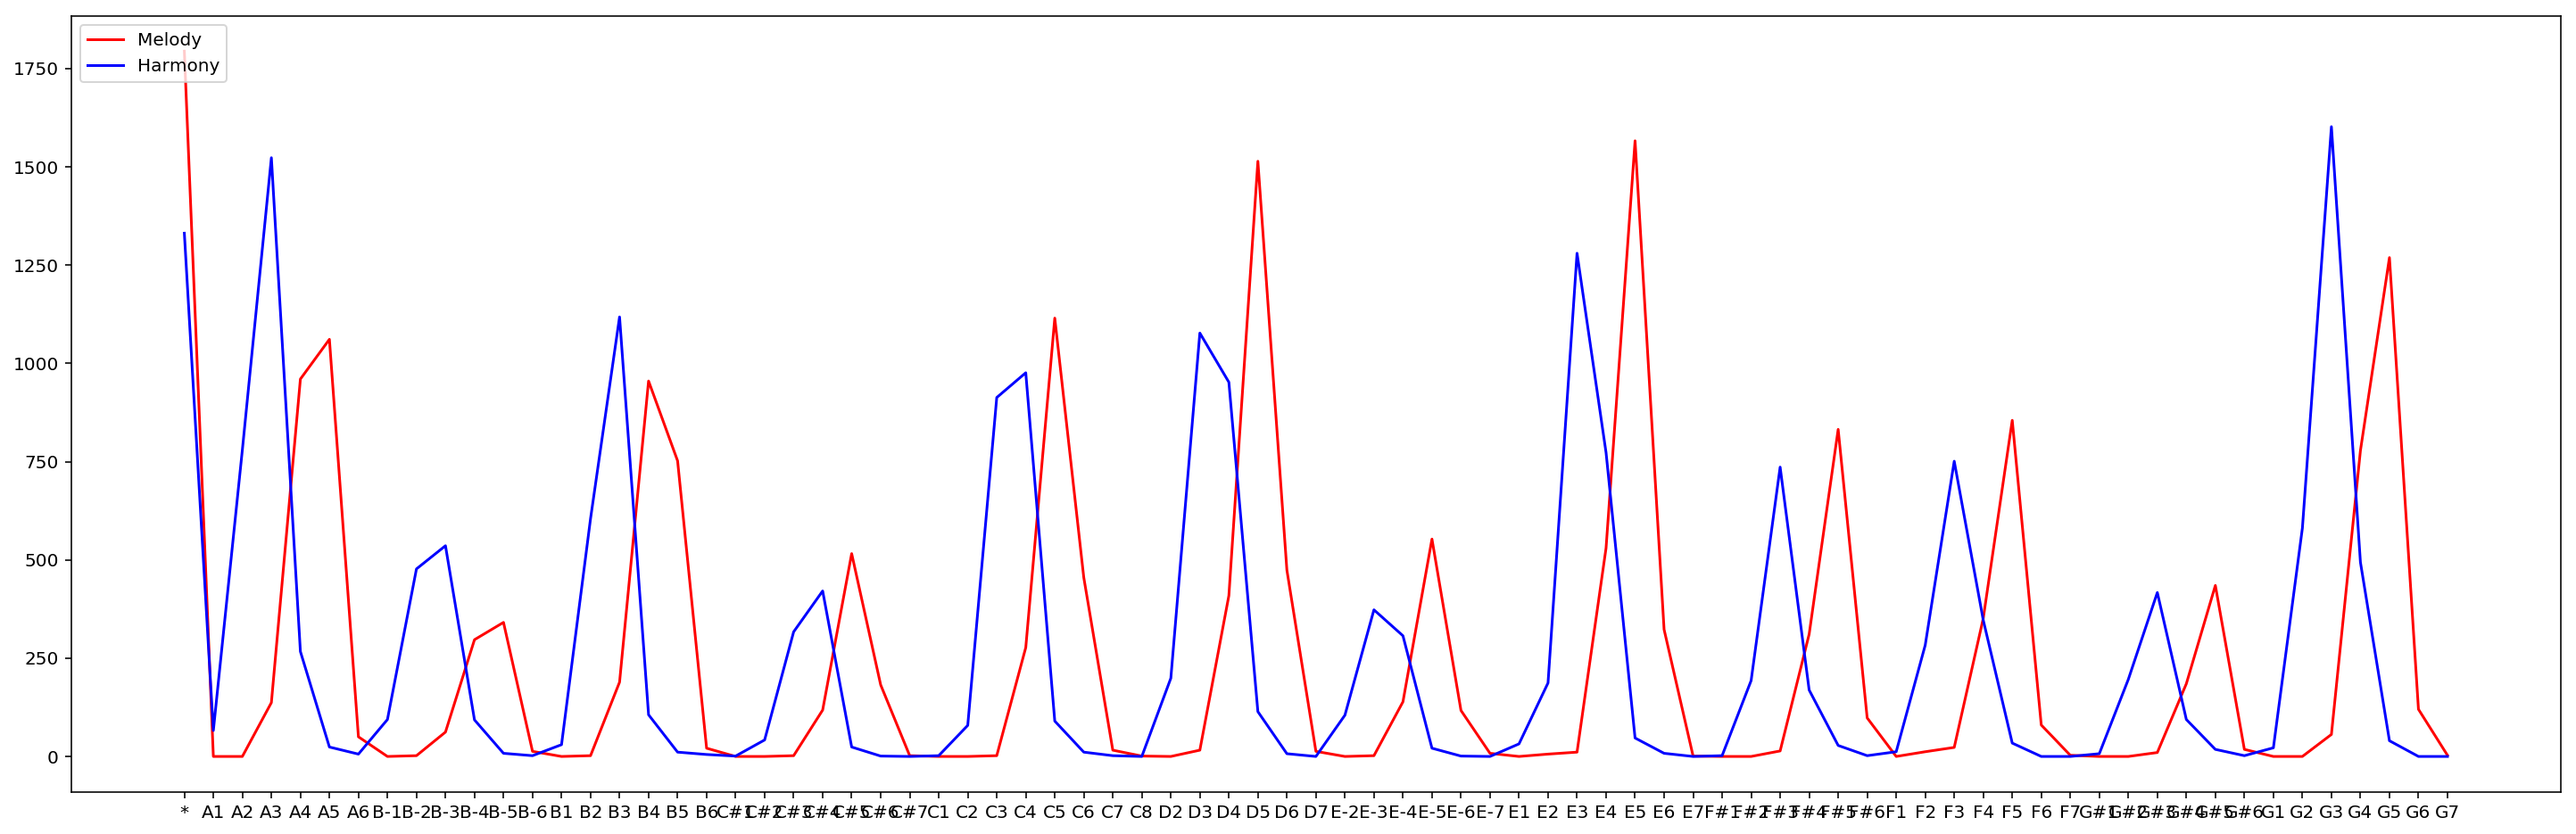

In [7]:
# get key set in the input stream. 
# Like get all characters set from an article 
import copy
import matplotlib.pyplot as plt

def get_all_keys(input_streams, output_streams):
    all_keys = [] # dot is also consider a "character" that shape our chord string
    input_all_freq = []
    output_all_freq = []
    for song in input_streams:
        for s in song:
            if s not in all_keys:
                all_keys.append(s)
                input_all_freq.append(1)
            else:
                idx = all_keys.index(s)
                input_all_freq[idx] += 1

    output_all_freq = [0] * len(input_all_freq)
    
    for song in output_streams:
        for s in song:
            if s not in all_keys:
                all_keys.append(s)
                output_all_freq.append(1)
            else:
                idx = all_keys.index(s)
                output_all_freq[idx] += 1

    input_all_freq = input_all_freq + [0] * (len(output_all_freq)-len(input_all_freq))
                
    return all_keys, input_all_freq, output_all_freq

            
all_keys, in_freq, out_freq = get_all_keys(train_input_streams, train_output_streams)
in_freq = [x for _,x in sorted(zip(copy.deepcopy(all_keys),copy.deepcopy(in_freq)))]
out_freq = [x for _,x in sorted(zip(copy.deepcopy(all_keys),copy.deepcopy(out_freq)))]
all_keys = sorted(all_keys)

key_idx_pair = dict([(char, i) for i, char in enumerate(all_keys)])

plt.figure(figsize=(25,8))
plt.plot(all_keys, in_freq, 'r', label="Melody")
plt.plot(all_keys, out_freq, 'b', label="Harmony")
plt.legend(loc='upper left')

print("Found {} keys used in all midi files".format(str(len(all_keys))))

In [8]:
# onehot encode encoder input data, decoder input data and decoder target data
# to feed in model
def onehot_encode(input_streams, output_streams, max_input_seq_num, max_output_seq_num, all_keys):
    encoder_input_data = np.zeros(
        (len(input_streams), max_input_seq_num, len(all_keys)))
    decoder_input_data = np.zeros(
        (len(output_streams), max_output_seq_num, len(all_keys)))
    decoder_target_data = np.zeros(
        (len(output_streams), max_output_seq_num, len(all_keys)))

    print(encoder_input_data.shape)
    print(decoder_input_data.shape)

    for i, (input_stream, output_stream) in enumerate(zip(input_streams, output_streams)):
        for t, char in enumerate(input_stream):
            encoder_input_data[i, t, key_idx_pair.get(char)] = 1.
        for t, char in enumerate(output_stream):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, key_idx_pair.get(char)] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, key_idx_pair.get(char)] = 1.
    return encoder_input_data, decoder_input_data, decoder_target_data

train_encoder_input_data, train_decoder_input_data, train_decoder_target_data \
= onehot_encode(train_input_streams, train_output_streams, max_input_seq_num, max_output_seq_num, all_keys)

test_encoder_input_data, test_decoder_input_data, test_decoder_target_data \
= onehot_encode(test_input_streams, test_output_streams, max_input_seq_num, max_output_seq_num, all_keys)


(102, 368, 79)
(102, 343, 79)
(12, 368, 79)
(12, 343, 79)


In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

# compile encoder-decoder model and train using the given parameters
# cont is a important parameter: 
# if cont is True: it will read the output_file_name from the weight folder and continue training 
# that weight file instead of overwrite 
def compile_and_train(batch_size, epochs, latent_dim, num_samples, output_file_name, cont=False):
    # encoder model
    # input
    encoder_inputs = Input(shape=(None, len(all_keys)))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # Encoder States
    encoder_states = [state_h, state_c]

    # decoder model
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    # input
    decoder_inputs = Input(shape=(None, len(all_keys)))
    decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
    # Activation Layer
    decoder_dense = Dense(len(all_keys), activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Run training
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    if cont:# continue training
        model.load_weights(output_file_name)

    filepath = output_file_name    
    checkpoint = ModelCheckpoint(
        filepath, monitor='loss', 
        verbose=1,        
        save_best_only=True,        
        mode='min'
    )    
    callbacks_list = [checkpoint]     

    model.fit([train_encoder_input_data, train_decoder_input_data], train_decoder_target_data,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_split=0.1,
              callbacks=callbacks_list)
    # Save model
    model.save(output_file_name)

    train_loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    tot_epoch = model.history.epoch
    config_detail = [batch_size, epochs, latent_dim, num_samples]
    
    total_history.append([config_detail, train_loss, val_loss, tot_epoch])

    
total_history = []

num_samples = len(train_input_streams)  # Number of samples to train on.
epochs = 80  # Number of epochs to train for.
# in the report it's [1, 8, 16]
batch_sizes = [1] 
# in the report it's [64, 128, 256]
latent_dims = [256]  # Latent dimensionality of the encoding space.

# The code here run every combination in the batch sizes list and latent dims list
# When epochs = 60, only 1 batch size is able to generate good music
# Change these parameters according to your need
for batch_size in batch_sizes:
    for latent_dim in latent_dims:
        output_file_name = "./weights_epoch_60/batch_{}_latent_{}_.h5".format(str(batch_size), str(latent_dim))
        compile_and_train(batch_size, epochs, latent_dim, num_samples, output_file_name, False)

Using TensorFlow backend.


Train on 91 samples, validate on 11 samples
Epoch 1/60
91/91 [==============================] - 58s 633ms/step - loss: 2.2493 - val_loss: 1.7834

Epoch 00001: loss improved from inf to 2.24929, saving model to ./weights_epoch_60/batch_1_latent_256_.h5


/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 56s 613ms/step - loss: 2.1729 - val_loss: 1.7589

Epoch 00002: loss improved from 2.24929 to 2.17289, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 3/60
91/91 [==============================] - 56s 613ms/step - loss: 2.1287 - val_loss: 1.7108

Epoch 00003: loss improved from 2.17289 to 2.12869, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 4/60
91/91 [==============================] - 57s 625ms/step - loss: 2.0348 - val_loss: 1.6410

Epoch 00004: loss improved from 2.12869 to 2.03483, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 5/60
91/91 [==============================] - 56s 614ms/step - loss: 1.9471 - val_loss: 1.5985

Epoch 00005: loss improved from 2.03483 to 1.94714, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 6/60
91/91 [==============================] - 56s 618ms/step - loss: 1.8771 - val_loss: 1.5532

Epoch 00006: loss improved from 1.94714 to 1.87708

91/91 [==============================] - 55s 602ms/step - loss: 0.9787 - val_loss: 1.5583

Epoch 00041: loss improved from 1.00983 to 0.97871, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 42/60
91/91 [==============================] - 55s 602ms/step - loss: 0.9711 - val_loss: 1.5702

Epoch 00042: loss improved from 0.97871 to 0.97114, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 43/60
91/91 [==============================] - 55s 603ms/step - loss: 0.9503 - val_loss: 1.5804

Epoch 00043: loss improved from 0.97114 to 0.95027, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 44/60
91/91 [==============================] - 55s 605ms/step - loss: 0.9223 - val_loss: 1.6099

Epoch 00044: loss improved from 0.95027 to 0.92234, saving model to ./weights_epoch_60/batch_1_latent_256_.h5
Epoch 45/60
91/91 [==============================] - 55s 605ms/step - loss: 0.8953 - val_loss: 1.6022

Epoch 00045: loss improved from 0.92234 to 0.89532, savin

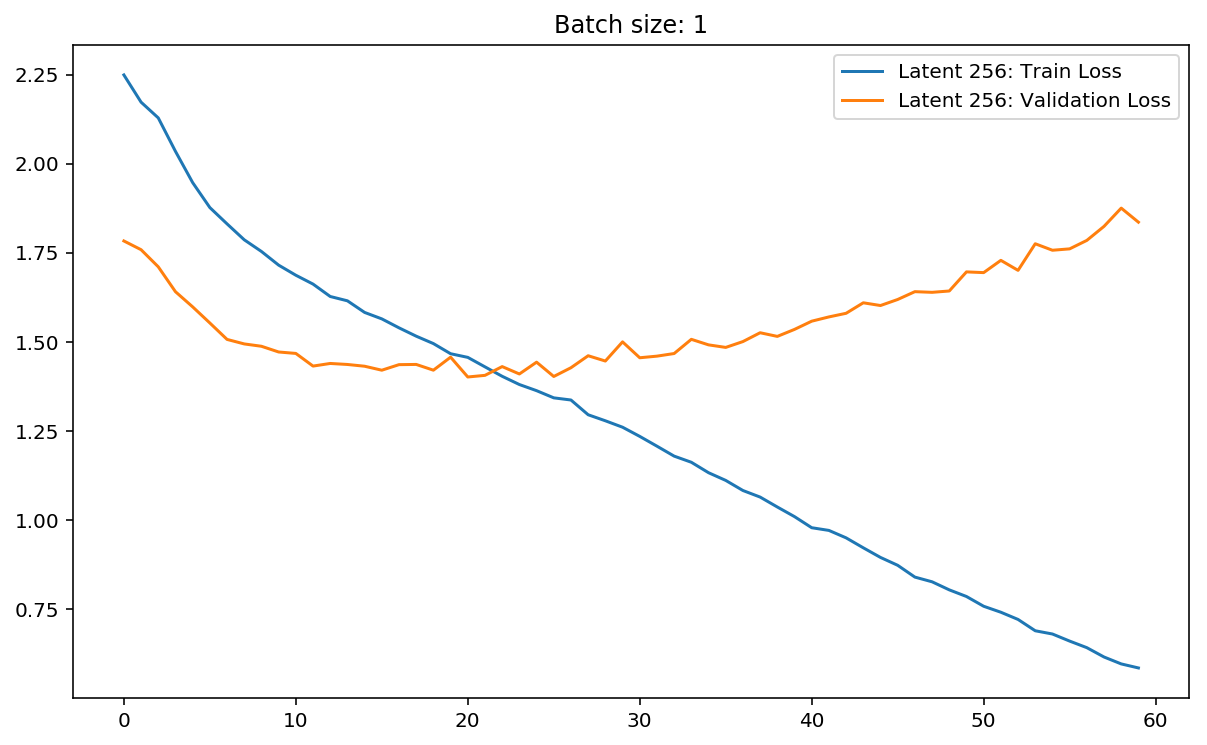

Batch Size: 1 Latent_dim: 256


In [10]:
# This function plot the relationship between training loss and vali loss
import math

def plot_performance(total_history):
    counter_tres = math.sqrt(len(total_history)) - 1
    counter = 0
    plt.rcParams["figure.figsize"] = [10,6]
    for each_config in total_history:
        config = each_config[0]
        train_loss = each_config[1]
        val_loss = each_config[2]
        tot_epoch = each_config[3]
        plt.plot(tot_epoch, train_loss, label="Latent {}: Train Loss".format(str(config[2])))
        plt.plot(tot_epoch, val_loss, label="Latent {}: Validation Loss".format(str(config[2])))
        plt.legend(loc='best')
        if counter >= counter_tres:
            counter = 0
            plt.title("Batch size: {}".format(str(config[0])))
            plt.show()
        else:
            counter += 1
        print("Batch Size: {} Latent_dim: {}".format(str(config[0]), str(config[2])))
plot_performance(total_history)


In [11]:
# modify this latent_dim according to the latent_dim weight you are loading or have trained
latent_dim = 256

# encoder model
encoder_inputs = Input(shape=(None, len(all_keys)))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Encoder States
encoder_states = [state_h, state_c]

# decoder model
decoder_inputs = Input(shape=(None, len(all_keys)))
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
# Activation Layer
decoder_dense = Dense(len(all_keys), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# load the weight you want to test on
model.load_weights("./weights/batch_1_latent_256_.h5")

#########################################################

# encoder model
# used when making a prediction for a new source sequence.
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model 
# use when making a prediction for a new source sequence.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# define model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in key_idx_pair.items())
reverse_target_char_index = dict(
    (i, char) for char, i in key_idx_pair.items())


In [16]:
# The "predict" function
# Given a input melody stream and the first token enlightment
# will return the decoded sequence
def decode_stream(input_stream, first_token):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_stream)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(all_keys)))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, key_idx_pair[first_token]] = 1.

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sequence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sequence.append(sampled_char)

        # exit if exceed input stream length
        if (len(decoded_sequence) > max_output_seq_num):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(all_keys)))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]
    

    return decoded_sequence

In [17]:
# convert a list of note string to a list of note object
def note_to_midi(seq):
    offset = 0
    output_notes = []

    for i in range(len(seq)):
        pattern = seq[i]
        new_note = None
        # if it's a rest
        if pattern == '*':
            new_note = note.Rest()
            new_note.offset = offset
        # if it's a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
        
        output_notes.append(new_note)
        offset += 0.5

    return output_notes

# The function takes an encoded melody matrix and the original melody note list
# make a left-hand piano stream and gives the option of playing both melody, harmony 
# and the combined part
def generate_music(input_data_matrix, input_data_seq, output_data_seq, idx):
    input_mat = input_data_matrix[idx:idx+1]
    input_seq = input_data_seq[idx]
    output_seq = output_data_seq[idx] # used for retrive the first token for enlightment
    # main melody 
    melody = note_to_midi(input_seq)
    melody = stream.Part(melody)
    # left hand generated by model
    harmony_seq = decode_stream(input_mat, output_seq[0])
    
    all_keys = [] 
    all_freq = []
    for key in harmony_seq:
        if key not in all_keys:
            all_keys.append(key)
            all_freq.append(1)
        else:
            idx = all_keys.index(key)
            all_freq[idx] += 1
    #print(all_freq)

    harmony = note_to_midi(harmony_seq)
    harmony = stream.Part(harmony)
    
    final_score = stream.Score()
    final_score.insert(0, melody)
    final_score.insert(0, harmony)
    
    melody.show('midi')
    #melody.show('text')
    harmony.show('midi')
    #harmony.show("text")
    final_score.show('midi')
    #final_score.show()
    
generate_music(test_encoder_input_data, test_input_streams, test_output_streams, 5)

In [18]:
generate_music(test_encoder_input_data, test_input_streams, test_output_streams, 4)